In [28]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from importlib import reload

import nlp_functions as NF

from sentence_transformers import SentenceTransformer
from sklearn.metrics import pairwise_distances, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

from constants import DATA_DIR, RNG, RANDOM_SEED

In [29]:
def get_col_stats(df, col='clusters'):
    tmp = df[col].value_counts(dropna=False)
    return {str(i): tmp[i] for i in tmp.index}   

In [30]:
def distance_cluster(df, encoded, train, test):
    # Assign Clusters Based on Prototypes
    distances = pairwise_distances(encoded[train], encoded[test])
    clusters = np.argmin(distances, axis=0)

    # Get labels of nearest labeled points
    pred_labels = df.loc[train, 'relevant'].values[clusters]
    return pred_labels

# distance_cluster(full_data, vec_encoded, train_partials[-1], test_partial)

In [31]:
def model_fit_predict(model, df, encoded, train, test):
    try:
        # Provide random seed for reproducibility, if relevent
        M = model(random_state=RANDOM_SEED)
    except TypeError:
        M = model()
    M.fit(encoded[train], df.loc[train, 'relevant'].astype(int))

    return M.predict(encoded[test])>0.5

In [32]:
def test_train_split(df, train_groups=10, train_ratio=0.8):
    # Group data by random index selection
    idxs = RNG.permutation(len(df))

    # 80-20 train-test split
    ival = int(train_ratio*len(df)/train_groups)+1

    # Get cumulative proportions of training sample as boolean masks
    train_partials = []
    for i in range(train_groups):
        tmp = np.zeros(len(df))
        tmp[idxs[:(i+1)*ival]] = 1
        train_partials.append(tmp.astype(bool))

    # Test is what's left-over after the last training mask
    test_partial = ~tmp.astype(bool)

    # print(sum(train_partials[-1]), sum(test_partial), len(df))
    return train_partials, test_partial

In [33]:
# The manually labeled sample
full_data = pd.read_parquet(os.path.join(DATA_DIR, 'Iter1', 'partial_labeled_100.par'))

In [34]:
# Encodings are shared across all label sets

# Simple (Tokenized) Vector Encoding
vec_encoded, tokens = NF.simple_vector_encode(full_data)
print(vec_encoded.shape)

# Sentence Transformer
model = SentenceTransformer('all-MiniLM-L12-v2')
sent_encoded = model.encode(full_data["title"].values, convert_to_tensor=False)
print(sent_encoded.shape)

(536, 1354)
(536, 384)


In [54]:
clusterer_stats = None

ensemble_misclassified_titles = []
for q in tqdm(range(10)):
    train_partials, test_partial = test_train_split(full_data)
    expected_labels = full_data.loc[test_partial, 'relevant'].values.astype(int)

    label_sets = {f'{10*(i+1):.0f}':p for i, p in enumerate(train_partials)}
    encodings = {'vec': vec_encoded, 'sent': sent_encoded}
    clusterers = {'PD': distance_cluster, 'SVM': SVC, 'Bayes': BernoulliNB, 'Logistic': LogisticRegression}

    data = {}
    for kd, d in label_sets.items():
        ensemble_names = []
        for kc, c in clusterers.items():
            for ke, e in encodings.items():
                name = (kd, kc, ke)
                # TEST
                if kc in ['Bayes', 'PD', 'SVM'] and ke == 'sent':
                    ensemble_names.append(name)
                if kc == 'PD':
                    pred = c(full_data, e, d, test_partial)
                else:
                    pred = model_fit_predict(c, full_data, e, d, test_partial)
                data[name] = pred
        data[(kd, 'ensemble')] = np.mean([data[n] for n in ensemble_names], 0)>0.5

    preds = [d.astype(int) for d in data.values()]
    scores = [f1_score(expected_labels, p) for p in preds]

    ensemble_misclassified_titles.extend(full_data.loc[test_partial, 'title'][data[('100', 'ensemble')] != expected_labels.astype(bool)].tolist())

    if clusterer_stats is None:
        clusterer_stats = pd.DataFrame({0: scores}, index=pd.MultiIndex.from_tuples(list(data.keys()), names=['Labels', 'Clusterer', 'Encoding']))
    else:
        clusterer_stats[q] = scores

100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


In [59]:
# Which titles does the ensemble have difficulty predicting?
values, counts = np.unique(ensemble_misclassified_titles, return_counts=True)
pairs = list(zip(counts, values))
pairs.sort(reverse=True)
[p[1] for p in pairs]

['MECCANIXITY Fiber Optic Rods PMMA 1.5mmx50cm for Sight Filament Green',
 '[Open Filament] da Vinci Jr Pro 3D Printer-6"x6"x6" Volume, Fully Enclosed (Includes 300g Filament, Maintenance Tools, PLA/Tough PLA/PETG) - Upgradable to Print Metallic/Carbon PLA',
 "MakerBot PLA 3D Printing Filament Large Spool for Use with MakerBot's Replicator+ & 5th Generation Line of 3D Printers, Non-Toxic Resin, 1.75mm Diameter, Black (MP05775)",
 'Creality CR-10S DIY 3D Printer Kit Large Printing Size 300x300x400mm Dual Z Axis and Filament Detector Use 1.75mm PLA Filament',
 'Polymaker Easy to Sand & Paint PLA Filament 1.75mm CosPLA (Version A), 1kg PLA 3D Printer Filament 1.75 - PolyLite 1.75 PLA Filament Easy Sanding for Cosplay, Dimensional Accuracy +/- 0.03mm',
 '3d Pen filament refill straight plastic, strands, sticks. 5 colors of ABS 3mm and 5 Colors of PLA 3mm - 50 stands, Any 3d pen using 3 mm Filament',
 'Promotion! Print-Rite CoLiDo Delta 3D Printer Kossel Kit D1315 Plus with High Printing Pr

In [9]:
clusterer_stats['F1-Scores'] = clusterer_stats[list(range(10))].mean(axis=1)
clusterer_stats['SDev'] = clusterer_stats[list(range(10))].std(axis=1)
clusterer_stats['FMin'] = clusterer_stats[list(range(10))].min(axis=1)
clusterer_stats['FMax'] = clusterer_stats[list(range(10))].max(axis=1)
clusterer_stats

0         1         2         3         4  \
Labels Clusterer Encoding                                                     
10     PD        vec       0.904255  0.944724  0.938776  0.907216  0.918367   
                 sent      0.923913  0.974093  0.942408  0.926316  0.931217   
       SVM       vec       0.890052  0.940000  0.934010  0.907216  0.918367   
                 sent      0.894737  0.940000  0.948454  0.907216  0.918367   
       Bayes     vec       0.890052  0.940000  0.929293  0.907216  0.918367   
...                             ...       ...       ...       ...       ...   
100    Bayes     vec       0.960452  0.973822  0.978723  0.972376  0.983607   
                 sent      0.988095  0.961326  0.977778  0.965517  0.977528   
       Logistic  vec       0.971429  0.994652  0.983957  0.983240  0.972973   
                 sent      0.949721  0.974093  0.989247  0.951351  0.972973   
       ensemble  NaN       1.000000  1.000000  1.000000  0.977778  0.994475   

                                  5         6         7         8         9  \
Labels Clusterer Encoding                                                     
10     PD        vec       0.911917  0.912821  0.900524  0.911917  0.923858   
                 sent      0.936842  0.936170  0.939891  0.936170  0.947917   
       SVM       vec       0.912821  0.912821  0.895833  0.907216  0.923858   
                 sent      0.917526  0.912821  0.905263  0.907216  0.923858   
       Bayes     vec       0.912821  0.912821  0.895833  0.907216  0.923858   
...                             ...       ...       ...       ...       ...   
100    Bayes     vec       0.972376  0.972678  0.966292  0.972376  0.973262   
                 sent      0.953488  0.948571  0.951220  0.977011  0.977528   
       Logistic  vec       0.967033  0.978022  0.966292  0.988764  0.994536   
                 sent      0.978022  0.972678  0.960894  0.961749  0.962963   
       ensemble  NaN       0.988889  0.978022  0.988506  0.983240  1.000000   

                           F1-Scores      SDev      FMin      FMax  
Labels Clusterer Encoding                                           
10     PD        vec        0.917437  0.014486  0.900524  0.944724  
                 sent       0.939494  0.014106  0.923913  0.974093  
       SVM       vec        0.914220  0.015601  0.890052  0.940000  
                 sent       0.917546  0.016353  0.894737  0.948454  
       Bayes     vec        0.913748  0.014996  0.890052  0.940000  
...                              ...       ...       ...       ...  
100    Bayes     vec        0.972596  0.006219  0.960452  0.983607  
                 sent       0.967806  0.013671  0.948571  0.988095  
       Logistic  vec        0.980090  0.010602  0.966292  0.994652  
                 sent       0.967369  0.012283  0.949721  0.989247  
       ensemble  NaN        0.991091  0.009130  0.977778  1.000000  

[90 rows x 14 columns]

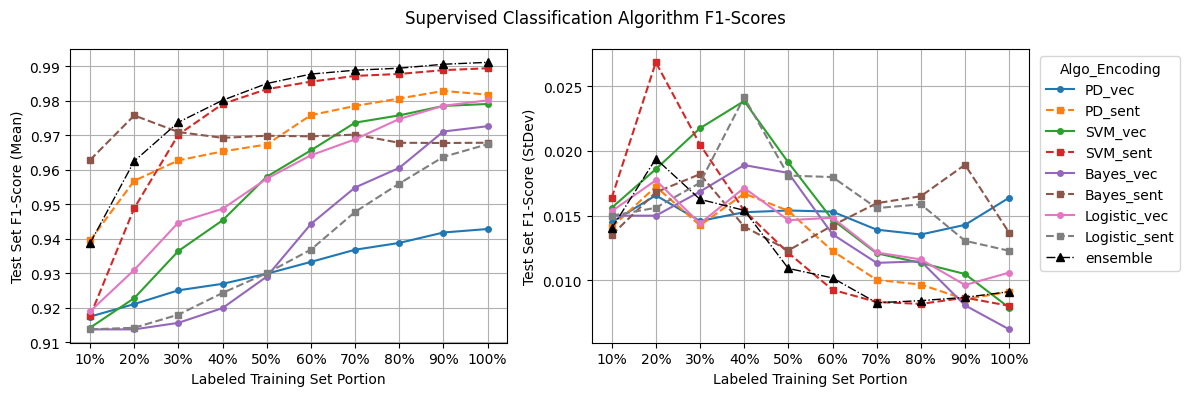

In [25]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 4)
axs = fig.axes

labels = ['_'.join([str(j) for j in i[1:]]) for i in clusterer_stats.index]
clusterer_stats['labels'] = labels

names = ['PD', 'SVM', 'Bayes', 'Logistic', 'ensemble']
X = np.array([10*i for i in range(1, 11)])
for v, c in enumerate(names):
    subset = clusterer_stats.xs(c, level=1)

    try:
        vec = subset.xs('vec', level=1)
        sent = subset.xs('sent', level=1)
        axs[0].plot(X, vec['F1-Scores'], 'o-', markersize=4)
        axs[1].plot(X, vec['SDev'], 'o-', markersize=4)

        axs[0].plot(X, sent['F1-Scores'], 's--', markersize=4)
        axs[1].plot(X, sent['SDev'], 's--', markersize=4)
    except KeyError:
        nan = subset.xs(np.nan, level=1)
        axs[0].plot(X, nan['F1-Scores'], 'k^-.', linewidth=1, markersize=6)
        axs[1].plot(X, nan['SDev'], 'k^-.', linewidth=1, markersize=6)

legend = clusterer_stats['labels'][:8].tolist() + ['ensemble']
plt.legend(legend, bbox_to_anchor=(1.01, 1), loc='upper left', title='Algo_Encoding')

for a in axs:
    a.set_xticks(X, [f'{x/100:.0%}' for x in X])
    a.set_xlabel('Labeled Training Set Portion')

axs[0].set_ylabel('Test Set F1-Score (Mean)')
axs[1].set_ylabel('Test Set F1-Score (StDev)')

plt.suptitle('Supervised Classification Algorithm F1-Scores')

axs[0].grid()
axs[1].grid()

plt.tight_layout()

plt.show()

In [21]:
def stats_to_table(df, col, savename):
    tmp = df.xs('vec', level=2)[col].reset_index()
    vec_table = tmp.pivot_table(col, 'Labels', columns=['Clusterer']).T

    tmp = df.xs('sent', level=2)[col].reset_index()
    sent_table = tmp.pivot_table(col, 'Labels', columns=['Clusterer']).T

    tmp = df.xs(np.nan, level=2)[col].reset_index()
    ensemble_table = tmp.pivot_table(col, 'Labels', columns=['Clusterer']).T

    combined = pd.concat({'sent': sent_table, 'vec': vec_table, '-': ensemble_table}, axis=0, names=['Encoding', 'Algorithm'])
    combined.columns.name = 'Manually Labeled'
    # Re-order columns
    combined = combined[[str(10*i) for i in range(1, 11)]]
    combined.rename(columns={str(10*i): f'{0.1*i:.0%}' for i in range(1, 11)}, inplace=True)

    combined.to_csv(os.path.join(DATA_DIR, savename))

    return combined

In [26]:
stats_to_table(clusterer_stats, 'F1-Scores', 'classifier_scores.csv')

Manually Labeled         10%       20%       30%       40%       50%  \
Encoding Algorithm                                                     
sent     Bayes      0.962797  0.975712  0.970916  0.969224  0.969829   
         Logistic   0.913748  0.914220  0.918006  0.924298  0.930014   
         PD         0.939494  0.956777  0.962695  0.965294  0.967292   
         SVM        0.917546  0.948831  0.970137  0.979029  0.983317   
vec      Bayes      0.913748  0.913748  0.915638  0.919920  0.929025   
         Logistic   0.918942  0.930965  0.944700  0.948663  0.957378   
         PD         0.917437  0.921071  0.925059  0.926940  0.929860   
         SVM        0.914220  0.922786  0.936442  0.945332  0.957967   
-        ensemble   0.938663  0.962478  0.973736  0.980103  0.984949   

Manually Labeled         60%       70%       80%       90%      100%  
Encoding Algorithm                                                    
sent     Bayes      0.969655  0.970157  0.967797  0.967733  0.967806  
         Logistic   0.936846  0.947764  0.955973  0.963718  0.967369  
         PD         0.975797  0.978464  0.980619  0.982810  0.981741  
         SVM        0.985495  0.987159  0.987730  0.988835  0.989382  
vec      Bayes      0.944268  0.954839  0.960524  0.971057  0.972596  
         Logistic   0.964173  0.968789  0.974686  0.978509  0.980090  
         PD         0.933292  0.936815  0.938788  0.941805  0.942819  
         SVM        0.965600  0.973624  0.975730  0.978470  0.979032  
-        ensemble   0.987694  0.988817  0.989395  0.990545  0.991091

In [27]:
stats_to_table(clusterer_stats, 'SDev', 'classifier_std.csv')

Manually Labeled         10%       20%       30%       40%       50%  \
Encoding Algorithm                                                     
sent     Bayes      0.013503  0.016800  0.018199  0.014158  0.012315   
         Logistic   0.014996  0.015601  0.017531  0.024133  0.018089   
         PD         0.014106  0.017239  0.014244  0.016700  0.015373   
         SVM        0.016353  0.026829  0.020485  0.015385  0.012119   
vec      Bayes      0.014996  0.014996  0.016852  0.018899  0.018295   
         Logistic   0.015330  0.017729  0.014398  0.017138  0.014644   
         PD         0.014486  0.016560  0.014585  0.015261  0.015395   
         SVM        0.015601  0.018587  0.021745  0.023845  0.019100   
-        ensemble   0.014008  0.019387  0.016256  0.015408  0.010924   

Manually Labeled         60%       70%       80%       90%      100%  
Encoding Algorithm                                                    
sent     Bayes      0.014235  0.015957  0.016496  0.018926  0.013671  
         Logistic   0.017974  0.015581  0.015869  0.013055  0.012283  
         PD         0.012271  0.010037  0.009678  0.008546  0.009125  
         SVM        0.009274  0.008334  0.008185  0.008663  0.008038  
vec      Bayes      0.013560  0.011350  0.011474  0.008072  0.006219  
         Logistic   0.014836  0.012154  0.011618  0.009642  0.010602  
         PD         0.015306  0.013914  0.013541  0.014286  0.016382  
         SVM        0.014681  0.012092  0.011348  0.010492  0.007892  
-        ensemble   0.010189  0.008271  0.008437  0.008690  0.009130

In [14]:
# tmp = clusterer_stats.xs('vec', level=2)['F1-Scores'].reset_index()
# tmp.pivot_table('F1-Scores', 'Labels', columns=['Clusterer']).T.to_csv(os.path.join(DATA_DIR, 'sup_algo_scores_vec.csv'))

In [15]:
# tmp = clusterer_stats.xs('sent', level=2)['F1-Scores'].reset_index()
# tmp.pivot_table('F1-Scores', 'Labels', columns=['Clusterer']).T.to_csv(os.path.join(DATA_DIR, 'sup_algo_scores_sent.csv'))